**2. domaci**
- kod se moze pokrenutii iz Google Colaboratory na Google Drive-u ili preko jupyter-a

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def draw(src_p, dst_p):
    xs = [p[0] for p in src_p]
    ys = [p[1] for p in src_p]
    xs.append(src_p[0][0])
    ys.append(src_p[0][1])

    xd = [p[0] for p in dst_p]
    yd = [p[1] for p in dst_p]
    xd.append(dst_p[0][0])
    yd.append(dst_p[0][1])

    plt.plot(xs, ys)
    plt.plot(xd, yd)
    plt.legend(['original', 'slika'])
    plt.show()

In [3]:
# originalne tacke
src_points = [[-3, -1, 1],
              [3, -1, 1],
              [1, 1, 1],
              [-1, 1, 1]]

# slike tacaka
dst_points = [[-2, -1, 1],
              [2, -1, 1],
              [2, 1, 1],
              [-2, 1, 1]]

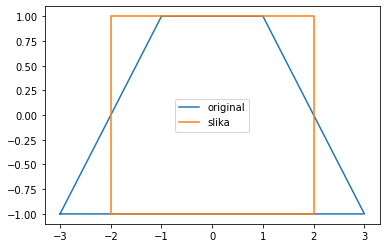

In [4]:
# Graficki prikaz
draw(src_points, dst_points)

***1. NAIVNI ALGORITAM***

In [5]:
def find_matrix(pts):
    matrix = np.array([ # A, B, C
        [pts[0][0], pts[1][0], pts[2][0]],
        [pts[0][1], pts[1][1], pts[2][1]],
        [pts[0][2], pts[1][2], pts[2][2]]
    ])

    D = np.array([pts[3][0], pts[3][1], pts[3][2]])

    # D = alpha*A + beta*B + gamma*C
    result = np.linalg.solve(matrix, D)

    alpha = result[0]
    beta = result[1]
    gamma = result[2]

    column1= np.array([alpha*pts[0][0], alpha*pts[0][1], alpha*pts[0][2]])
    column2= np.array([beta*pts[1][0], beta*pts[1][1], beta*pts[1][2]])
    column3= np.array([gamma*pts[2][0], gamma*pts[2][1], gamma*pts[2][2]])

    P = np.column_stack([column1, column2, column3])

    return P

def naive_algorithm(src_p, dst_p):

    P1 = find_matrix(src_p)
    P2 = find_matrix(dst_p)

    # P = P2*inv(P1)
    P = np.dot(P2, np.linalg.inv(P1))

    return P

In [6]:
# Matrica projektivnog preslikavanja
P_naive = naive_algorithm(src_points, dst_points)
P_naive = P_naive.round(5)
print(P_naive)

[[ 2. -0.  0.]
 [-0.  2. -1.]
 [ 0. -1.  2.]]


***2. DLT ALGORITAM***

In [7]:
def dlt(src_p, dst_p):
    x = src_p[0][0]
    y = src_p[0][1]
    z = src_p[0][2]

    u = dst_p[0][0]
    v = dst_p[0][1]
    w = dst_p[0][2]

    A = np.array([
        [0, 0, 0, -w*x, -w*y, -w*z, v*x, v*y, v*z],
        [w*x, w*y, w*z, 0, 0, 0, -u*x, -u*y, -u*z]
    ])

    for i in range(1, len(src_p)):
        x = src_p[i][0]
        y = src_p[i][1]
        z = src_p[i][2]

        u = dst_p[i][0]
        v = dst_p[i][1]
        w = dst_p[i][2]

        row1 = np.array([0, 0, 0, -w*x, -w*y, -w*z, v*x, v*y, v*z])
        row2 = np.array([w*x, w*y, w*z, 0, 0, 0, -u*x, -u*y, -u*z])

        A = np.vstack((A, row1))
        A = np.vstack((A, row2))

    # print(A.shape)
    # print(A)

    # SVD dekompozicija
    U, S, V = np.linalg.svd(A)

    P = V[-1].reshape(3,3)
    
    return P

In [8]:
P_dlt = dlt(src_points, dst_points)
print(P_dlt.round(5))

[[ 0.53452  0.      -0.     ]
 [-0.       0.53452 -0.26726]
 [-0.      -0.26726  0.53452]]


***Poredjenje DLT i naivnog algoritma***

In [9]:
P_dlt = (P_dlt / P_dlt[0, 0]) * P_naive[0, 0]
print(P_dlt.round(5))

[[ 2.  0. -0.]
 [-0.  2. -1.]
 [-0. -1.  2.]]


In [10]:
P_dlt.round(5) == P_naive.round(5)

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

***3. MODIFIKOVANI DLT ALGORITAM***

In [11]:
def normalization(src_p):
    
    # teziste sistema tacaka C(x, y)
    x = sum([p[0]/p[2] for p in src_p]) / len(src_p)
    y = sum([p[1]/p[2] for p in src_p]) / len(src_p)
    
    # srednje rastojanje
    r = 0.0

    for i in range(len(src_p)):
        # translacija u koordinatni pocetak
        tmp1 = float(src_p[i][0]/src_p[i][2]) - x
        tmp2 = float(src_p[i][1]/src_p[i][2]) - y

        r = r + math.sqrt(tmp1**2 + tmp2**2)

    r = r / float(len(src_p))

    # skaliranje
    S = float(math.sqrt(2)) / r

    # vracamo matricu normalizacije 
    return np.array([[S, 0, -S*x], [0, S, -S*y], [0, 0, 1]])

def dlt_normalized(src_p, dst_p):

    # transformacije
    T = normalization(src_p)
    T_prim = normalization(dst_p)

    # normalizovane tacke
    M_line = T.dot(np.transpose(src_p))
    M_prim = T_prim.dot(np.transpose(dst_p))

    M_line = np.transpose(M_line)
    M_prim = np.transpose(M_prim)

    P_line = dlt(M_line, M_prim)

    P = (np.linalg.inv(T_prim)).dot(P_line).dot(T)

    return P

In [12]:
P_dlt_norm = dlt_normalized(src_points, dst_points)
print(P_dlt_norm.round(5))

[[ 0.50972  0.       0.     ]
 [-0.       0.50972 -0.25486]
 [ 0.      -0.25486  0.50972]]


***Poredjenje DLT i modifikovanog DLT algoritma***

In [13]:
P_dlt_norm = (P_dlt_norm / P_dlt_norm[0, 0]) * P_dlt[0, 0]
print(P_dlt_norm.round(5))

[[ 2.  0.  0.]
 [-0.  2. -1.]
 [ 0. -1.  2.]]


In [14]:
P_dlt_norm.round(5) == P_dlt.round(5)

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

***DLT sa vise korespodencija***

In [15]:
# originalne tacke
src_points = [[-3, -1, 1],
              [3, -1, 1],
              [1, 1, 1],
              [-1, 1, 1],
              [1, 2, 3],
              [-8, -2, 1]]

# slike tacaka
dst_points = [[-2, -1, 1],
              [2, -1, 1],
              [2, 1, 1],
              [-2, 1, 1],
              [2, 1, 4],
              [-16, -5, 4]]

In [16]:
# DLT za vise od 4 korespodencije
P_dlt_new = dlt(src_points, dst_points)
print(P_dlt_new.round(5))
# Poredjenje sa naivnim
P_dlt_new = (P_dlt_new / P_dlt_new[0, 0]) * P_naive[0, 0]
print(P_dlt_new.round(5))
# dobijamo isto preslikavanje
print(P_dlt_new.round(5) == P_naive.round(5))

[[-0.53452  0.      -0.     ]
 [ 0.      -0.53452  0.26726]
 [-0.       0.26726 -0.53452]]
[[ 2. -0.  0.]
 [-0.  2. -1.]
 [ 0. -1.  2.]]
[[ True  True  True]
 [ True  True  True]
 [ True  True  True]]


In [17]:
# DLT modifikovani za vise od 4 korespodencije
P_dlt_norm_new = dlt_normalized(src_points, dst_points)
print(P_dlt_norm_new.round(5))
# Poredjenje sa naivnim
P_dlt_norm_new = (P_dlt_norm_new / P_dlt_norm_new[0, 0]) * P_naive[0, 0]
print(P_dlt_norm_new.round(5))
# dobijamo isto preslikavanje
print(P_dlt_norm_new.round(5) == P_naive.round(5))

[[-0.397  -0.      0.    ]
 [-0.     -0.397   0.1985]
 [ 0.      0.1985 -0.397 ]]
[[ 2.  0. -0.]
 [ 0.  2. -1.]
 [-0. -1.  2.]]
[[ True  True  True]
 [ True  True  True]
 [ True  True  True]]


***Promena koordinata kod DLT algoritama***



In [18]:
def change_coordinates():

    C1 = np.array([[0, 1, 2], 
                   [-1, 0, 3], 
                   [0, 0, 1]])
    
    C2 = np.array([[1, -1, 5], 
                   [1, 1, -2], 
                   [0, 0, 1]])

    src_points_new = []
    dst_points_new = []

    # nove tacke
    for i in range(len(src_points)):
        src_points_new.append(np.dot(C1, src_points[i]))
        dst_points_new.append(np.dot(C2, dst_points[i]))
 
    src_points_new = np.array(src_points_new)
    dst_points_new = np.array(dst_points_new)

    # DLT algoritam
    P_dlt = dlt(src_points, dst_points) 
    P_dlt_new = dlt(src_points_new, dst_points_new)
  
    P_tmp = np.dot(np.linalg.inv(C2), P_dlt_new)
    P_tmp = np.dot(P_tmp, C1)
    P_tmp = (P_dlt[0] / P_tmp[0]) * P_tmp
    
    print("Poredjenje DLT algoritma nakon promene koordinata: ")
    print(P_dlt.round(5) == P_tmp.round(5))
    # vidimo da vise nije ista matrica preslikavanja

    # Modifikovani DLT algoritam
    P_dlt_norm = dlt_normalized(src_points, dst_points)
    P_dlt_norm_new = dlt_normalized(src_points_new, dst_points_new)

    P_tmp = np.dot(np.linalg.inv(C2), P_dlt_norm_new)
    P_tmp = np.dot(P_tmp, C1)
    
    print("Poredjenje modifikovanog DLT algoritma nakon promene koordinata: ")
    print(P_dlt_norm.round(5) == P_tmp.round(5))
    # matrica je ista


In [19]:
change_coordinates()

Poredjenje DLT algoritma nakon promene koordinata: 
[[ True  True  True]
 [ True False False]
 [ True False False]]
Poredjenje modifikovanog DLT algoritma nakon promene koordinata: 
[[ True  True  True]
 [ True  True  True]
 [ True  True  True]]


***4. UKLANJANJE PROJEKTIVNE DISTORZIJE***

In [ ]:
from PIL import Image

In [ ]:
img = Image.open('building.jpeg')
img_copy = Image.new('RGB', (img.size[0], img.size[1]), 'black')         

In [ ]:
def change_photo(src_p, dst_p):
    
    # P = naive_algorithm(src_p, dst_p)
    # P = dlt(src_p, dst_p)
    P = dlt_normalized(src_p, dst_p)

    P = np.linalg.inv(P)
    cols = img_copy.size[0]
    rows = img_copy.size[1]

    for i in range(cols):        
        for j in range(rows):      
            new_coord = P.dot([i, j, 1]) 
            new_coord = [(x / new_coord[2]) for x in new_coord]
            
            if (new_coord[0] >= 0 and new_coord[0] < cols-1 and new_coord[1] >= 0 and new_coord[1] < rows-1):
                tmp1 = img.getpixel((math.floor(new_coord[0]), math.floor(new_coord[1])))
                tmp2 = img.getpixel((math.ceil(new_coord[0]), math.ceil(new_coord[1])))
                img_copy.putpixel((i, j), tmp2)
        

    fig = plt.figure(figsize=(16, 9))

    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Pocetna slika:')

    plt.subplot(1, 2, 2)
    plt.imshow(img_copy)
    plt.title('Uklanjanje distorzije:')

    plt.tight_layout()
    plt.show()

In [ ]:
# tacke sa originalne slike (building.jpeg)
src_points = [[164, 717, 1],
              [294, 744, 1],
              [293, 147, 1],
              [214, 30, 1]]  

# primer ulaza za moju sliku:
# dst_points = [[164, 717, 1],
#               [294, 717, 1],
#               [294, 30, 1],
#               [164, 30, 1]] 

dst_points = [[0, 0, 0],
              [0, 0, 0],
              [0, 0, 0], 
              [0, 0, 0]]

print("Uneti afine koordinate 4 temena pravougaonika:")
for i in range(4):
    dst_points[i][0] = float(input("x koordinata: "))
    dst_points[i][1] = float(input("y koordinata: "))
    dst_points[i][2] = 1

change_photo(src_points, dst_points)

***4'. PANORAMA***

In [ ]:
import cv2
import math
import imageio
import imutils
import numpy as np
import matplotlib.pyplot as plt
cv2.ocl.setUseOpenCL(False)

In [ ]:
# sledece dve komande su kako bi mi radio SIFT
# (nakon njih je potrebno restartovati okruzenje)

In [ ]:
# pip install opencv-python==3.4.2.16

In [ ]:
# pip install opencv-contrib-python==3.4.2.16

In [ ]:
# ucitavanja slika i njihov prikaz
img2 = imageio.imread('img2.jpg')
img2_gray = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

img1 = imageio.imread('img1.jpg')
img1_gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(16,9))
ax1.imshow(img1, cmap="gray")
ax2.imshow(img2, cmap="gray")

plt.show()

In [ ]:
# detektovanje tacaka na slici
descriptor = cv2.xfeatures2d.SIFT_create()

kpA, featuresA = descriptor.detectAndCompute(img2_gray, mask=None)
kpB, featuresB = descriptor.detectAndCompute(img1_gray, mask=None)

In [ ]:
# prikaz kljucnih tacaka na slikama
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
ax1.imshow(cv2.drawKeypoints(img2_gray, kpA, None, color=(0,255,0)))
ax2.imshow(cv2.drawKeypoints(img1_gray, kpB, None, color=(0,255,0)))

plt.show()

In [ ]:
def bf_match(featuresA, featuresB):
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
        
    best_matches = bf.match(featuresA, featuresB)
    
    rawMatches = sorted(best_matches, key = lambda x:x.distance)

    return rawMatches

In [ ]:
# prikaz povezanosti tacaka sa slika
fig = plt.figure(figsize=(20,8))

matches = bf_match(featuresA, featuresB)

img3 = cv2.drawMatches(img2, kpA, img1, kpB, matches[:100], None,
                       flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(img3)
plt.show()

In [ ]:
# RANSAC
def homography(kpA, kpB, featuresA, featuresB, matches, reprojThresh):
    
    kpA = np.float32([kp.pt for kp in kpA])
    kpB = np.float32([kp.pt for kp in kpB])
    
    if len(matches) > 4:
        ptsA = np.float32([kpA[m.queryIdx] for m in matches])
        ptsB = np.float32([kpB[m.trainIdx] for m in matches])
        
        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
            reprojThresh)

        return (matches, H, status)
    else:
        return None

In [ ]:
(_, H, _) = homography(kpA, kpB, featuresA, featuresB, matches, reprojThresh=4)
print(H)

In [ ]:
# transformisanje
width = img2.shape[1] + img1.shape[1]
height = img2.shape[0] + img1.shape[0]

res = cv2.warpPerspective(img2, H, (width, height))
res[0:img1.shape[0], 0:img1.shape[1]] = img1

plt.figure(figsize=(20,10))
plt.imshow(res)

plt.show()

In [ ]:
# uklanjanje viska crnog u rezultatu
gray = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

# trazi se povrsina crne oblasti
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

c = max(cnts, key=cv2.contourArea)
(x, y, w, h) = cv2.boundingRect(c)

res = res[y:y + h, x:x + w]

plt.figure(figsize=(20,10))
plt.imshow(res)